# Deconvolution with DSEA

The Dortmund Spectrum Estimation Algorithm (DSEA) reconstructs the target distribution from classifier predictions on the target quantity of individual examples.
CherenkovDeconvolution.py implements the improved version DSEA+, which is extended by adaptive step sizes and a fixed reweighting of examples.

For a quick start, we deconvolve the distribution of Iris plant types in the famous IRIS data set.

In [1]:
import numpy as np
from cherenkovdeconvolution import util

# load the data
from sklearn.datasets import load_iris
iris = load_iris()

# randomly split into training set and data to be deconvolved
np.random.seed(42)
p_iris = np.random.permutation(len(iris.target))
X_data  = iris.data[p_iris[0:50], :]
X_train = iris.data[p_iris[50:150], :]
y_train = iris.target[p_iris[50:150]]

# also obtain the true target density---which we are estimating---for validation
f_true = util.fit_pdf(iris.target[p_iris[0:50]]) # pdf of y values belonging to X_data
f_true

array([0.38, 0.3 , 0.32])

In [2]:
# workaround if you have not yet installed CherenkovDeconvolution.py but want to try it from this notebook
import sys
sys.path.append("..")

In [3]:
#
# Now let's estimate the target distribution!
#
from cherenkovdeconvolution import dsea
from sklearn.naive_bayes import GaussianNB

# deconvolve with a Naive Bayes classifier
f_est = dsea(X_data, X_train, y_train, GaussianNB()) # perform a single iteration of DSEA with step size one
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_est, f_true)))
f_est

Chi square distance between f_est and f_true: 0.001396749429286623


array([0.38      , 0.28530924, 0.33469076])

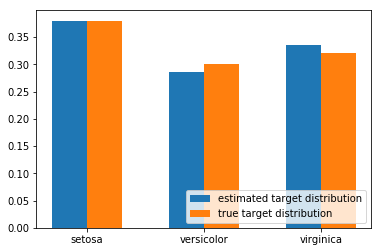

In [4]:
# 
# ...And we check the estimate by comparing it to the true distribution (which we would not know, in practice)
# 
%matplotlib inline
import matplotlib.pyplot as plt

# prepare plot
fig, ax = plt.subplots()
index = np.arange(3)
barwidth = .3

# add bar plots
ax.bar(index,            f_est,  barwidth, label='estimated target distribution')
ax.bar(index + barwidth, f_true, barwidth, label='true target distribution')
ax.legend(loc = 'lower right')

# show plot
plt.xticks(index + barwidth / 2, iris.target_names)
plt.show()

# 
# Looks good, huh?  :)
# 

In [5]:
# 
# You can find more information in the documentation
# 
help(dsea)


Help on function deconvolve in module cherenkovdeconvolution.methods.dsea:

deconvolve(X_data, X_train, y_train, classifier, bins=None, f_0=None, fixweighting=True, alpha=1, smoothing=None, K=1, epsilon=0.0, inspect=None, return_contributions=False)
    Deconvolve the target distribution of X_data with DSEA, learning from X_train and
    y_train.
    
    Parameters
    ----------
    X_data : array-like, shape (n_samples, n_features), floats
        The data from which the target distribution is deconvolved.
    
    X_train : array-like, shape (n_samples_train, n_features), floats
        The data from which the classifier is trained.
    
    y_train : array-like, shape (n_samples_train,), nonnegative ints
        The indices of target quantity values belonging to X_train.
    
    classifier: object
        A classifier that is trained with classifier.fit(X_train, y_train, w_train) to
        obtain a matrix of probabilities with classifier.predict_proba(X_data).
        Any sklear

## Decaying Step Sizes

DSEA searches the space of all possible results for a suitable estimate of the true target distribution. In each iteration, it takes a step through that space, which can be scaled in order to improve the convergence behaviour of the algorithm.

CherenkovDeconvolution.py contains the `stepsize` module for that purpose.

In [6]:
import cherenkovdeconvolution.stepsize as stepsize

# first of all, we set up an inspection function, which prints the step size of each iteration
def inspect_alpha(k, alpha, chi2s, f): # you can define custom inspection methods to investigate DSEA
    print(alpha)

# There are two decay rates, the first of which is comparably slow
alpha_mul = stepsize.decay_mul(0.5)
f_est_mul = dsea(X_data, X_train, y_train, GaussianNB(), K = 3, inspect = inspect_alpha, alpha = alpha_mul)

0
1
2
3


In [7]:
# The other one decays exponentially, which is rather fast
alpha_exp = stepsize.decay_exp(0.5, 2.0) # start with step size 2
f_est_exp = dsea(X_data, X_train, y_train, GaussianNB(), K = 3, inspect = inspect_alpha,  alpha = alpha_exp)

0
1
2
3


In [8]:
help(stepsize.decay_mul) # decay_exp would compute  alpha_k = start * eta**(k-1)

Help on function decay_mul in module cherenkovdeconvolution.stepsize:

decay_mul(eta, start=1.0)
    Construct a function object for a decaying stepsize in DSEA.
    
    The returned function describes a slow decay  alpha_k = start * k**(eta-1),  where k is
    the iteration number.
    
    Parameters
    ----------
    eta : float
        The decay rate. eta = 1 means no decay, eta = 0 means decay with medium speed 1/k,
        and eta = .5 means alpha_k = 1/sqrt(k), for example.
    
    start : float, optional
        The initial step size, which is 1, by default.
    
    Returns
    ----------
    alpha_fun : callable
        The stepsize function (k, pk, f_prev) -> float, which can be used as the alpha
        argument in DSEA.



## Adaptive Step Sizes

DSEA+ adapts its step size dynamically to each iteration. The choice if the step size is based on the objective function of the classical RUN algorithm. RUN maximizes a likelihood function in order to obtain a deconvolution result. DSEA+ evaluates RUN's likelihood function in the direction of search to find an optimal step size alpha.

Evaluating the likelihood function requires a discrete representation of examples `(x, y)` where `x` is an integer representing the cluster of the example in the feature space and `y` is an integer representing the label. The first step is thus to discretize the data.

In [9]:
from cherenkovdeconvolution.discretize import TreeDiscretizer
discretizer = TreeDiscretizer(X_train, y_train, 4) # interpret the 4 leaves of a decision tree as clusters
x_data  = discretizer.discretize(X_data)
x_train = discretizer.discretize(X_train)
alpha = stepsize.alpha_adaptive_run(x_data, x_train, y_train, tau = 0, bins_y = [0, 1, 2]) # a function object like above

# inspect the chosen alpha values with a callback function
def inspect_alpha(f, k, a, chi2s): # this signature is mandatory. Here, f is the latest estimate.
    print('Iteration {}: alpha = {}'.format(k, a)) # print iteration number and alpha value

# deconvolve
f_est = dsea(X_data, X_train, y_train, GaussianNB(), K = 6, alpha = alpha, inspect = inspect_alpha)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_est, f_true)))
f_est # Chi square distance of single-iteration DSEA was 0.001396749429286623

Iteration 0: alpha = nan
Iteration 1: alpha = 0.7454175894178066
Iteration 2: alpha = 4.887427306975944e-13
Iteration 3: alpha = 8.093233510131406e-13
Iteration 4: alpha = 1.2409091528698267e-12
Iteration 5: alpha = 6.808813911605976e-13
Iteration 6: alpha = 6.850920443326597e-13
Chi square distance between f_est and f_true: 0.0010266467681069556


array([0.36811949, 0.29753533, 0.33434518])